In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd/content/drive/My Drive/NIDS

/content/drive/My Drive/NIDS


In [ ]:
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

df = pd.read_csv("KDDTrain.csv", header=None, names = col_names)
df_test = pd.read_csv("KDDTest.csv", header=None, names = col_names)

print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22543, 42)


In [ ]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [ ]:
print('Label distribution Training set:')
print(df['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9710
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


In [ ]:
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))
print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [ ]:
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 63 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]
df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [ ]:
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

In [ ]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head(10))
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9
5              1       49     1
6              1       49     5
7              1       49     5
8              1       51     5
9              1       49     5


In [ ]:
enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)
df_cat_data.shape
#df_cat_data.head()

(125973, 84)

In [ ]:
testdf_cat_data.shape

(22543, 77)

In [ ]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_tftp_u',
 'service_aol',
 'service_http_8001',
 'service_urh_i',
 'service_harvest',
 'service_http_2784',
 'service_red_i']

In [ ]:
for col in difference:
    testdf_cat_data[col] = 0
testdf_cat_data.shape

(22543, 84)

In [ ]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print('Dimensions of the Training set:',newdf.shape)
print('Dimensions of the Test set:',newdf_test.shape)

Dimensions of the Training set: (125973, 123)
Dimensions of the Test set: (22543, 123)


In [ ]:
labeldf=newdf['label']
labeldf_test=newdf_test['label']
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})

newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test
print(newdf['label'].head())

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64


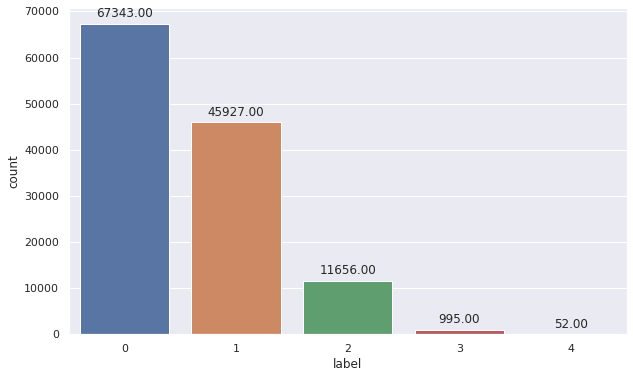

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x=newdf['label'], data=newdf)
for p in ax.patches:
  ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

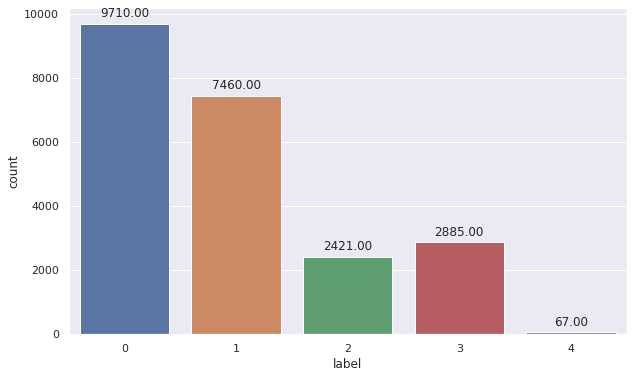

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x=newdf_test['label'], data=newdf_test)
for p in ax.patches:
  ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
X_train,Y_train,X_test,Y_test = newdf,newdf['label'],newdf_test,newdf_test['label']

In [ ]:
colNames=list(X_train)
colNames_test=list(X_test)

In [ ]:
from sklearn import preprocessing
scaler1 = preprocessing.StandardScaler().fit(X_train)
X_train=scaler1.transform(X_train) 

In [ ]:
X_train.std(axis=0);

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
selector=SelectPercentile(f_classif, percentile=30)#20-73%,
train_X_new = selector.fit_transform(X_train,Y_train)
train_X_new.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16] are constant.
  UserWarning)


(125973, 37)

In [ ]:
true=selector.get_support()
newcolindex=[i for i, x in enumerate(true) if x]
newcolname=list( colNames[i] for i in newcolindex )
print(newcolname)

['duration', 'hot', 'logged_in', 'root_shell', 'is_guest_login', 'count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_domain_u', 'service_eco_i', 'service_ftp', 'service_ftp_data', 'service_http', 'service_other', 'service_private', 'flag_REJ', 'flag_RSTR', 'flag_S0', 'flag_SF']


In [ ]:
X_test = X_test[newcolname]
scaler2 = preprocessing.StandardScaler().fit(X_test)
X_test=scaler2.transform(X_test) 
X_test.shape

(22543, 37)

In [ ]:
print('Dimensions of the Training set after feature selection:',train_X_new.shape)
print('Dimensions of the Test set after selected features:',X_test.shape)

Dimensions of the Training set after feature selection: (125973, 37)
Dimensions of the Test set after selected features: (22543, 37)


In [ ]:
train_X = torch.Tensor(train_X_new)
train_y = torch.Tensor(Y_train).long()
test_X = torch.Tensor(X_test)
test_y = torch.Tensor(Y_test).long()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
train_X = train_X.to(device)
train_y = train_y.to(device)
test_X = test_X.to(device)
test_y = test_y.to(device)

In [ ]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(25, 600)
        self.fc2 = nn.Linear(600, 600)
        self.fc3 = nn.Linear(600, 400)
        self.fc4 = nn.Linear(400, 400)
        self.fc5 = nn.Linear(400, 200)
        self.fc6 = nn.Linear(200, 200)
        self.fc7 = nn.Linear(200, 100)
        self.fc8 = nn.Linear(100, 100)
        self.fc9 = nn.Linear(100, 5)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        X = self.fc4(X)
        X = F.relu(self.fc4(X))
        X = self.fc5(X)
        X = self.fc6(X)
        X = F.relu(self.fc6(X))
        X = self.fc7(X)
        X = self.fc8(X)
        X = F.relu(self.fc8(X))
        X = self.fc9(X)
        X = self.softmax(X)
        return X

In [ ]:
def evaluation(X,Y):
  total, correct = 0, 0
  outputs = net(X)
  _, pred = torch.max(outputs.data, 1)
  total += Y.size(0)
  correct += (pred == Y).sum().item()
  return 100 * correct / total

In [ ]:
net = Net().to(device)
loss_epoch = []
criterion = nn.CrossEntropyLoss()# cross entropy loss
optimizer = torch.optim.SGD(net.parameters(), lr=0.01,momentum=0.9)
max_epochs = 200

number of epoch 0 loss tensor(1.6069, device='cuda:0')
Epoch: 0/200, Test acc: 43.07, Train acc: 53.46
Epoch: 1/200, Test acc: 43.07, Train acc: 53.46
Epoch: 2/200, Test acc: 43.07, Train acc: 53.46
Epoch: 3/200, Test acc: 43.07, Train acc: 53.46
Epoch: 4/200, Test acc: 43.07, Train acc: 53.46
Epoch: 5/200, Test acc: 43.07, Train acc: 53.46
Epoch: 6/200, Test acc: 43.07, Train acc: 53.46
Epoch: 7/200, Test acc: 43.07, Train acc: 53.46
Epoch: 8/200, Test acc: 43.07, Train acc: 53.46
Epoch: 9/200, Test acc: 43.07, Train acc: 53.46
number of epoch 10 loss tensor(1.6008, device='cuda:0')
Epoch: 10/200, Test acc: 43.07, Train acc: 53.46
Epoch: 11/200, Test acc: 43.07, Train acc: 53.46
Epoch: 12/200, Test acc: 43.07, Train acc: 53.46
Epoch: 13/200, Test acc: 43.07, Train acc: 53.46
Epoch: 14/200, Test acc: 43.07, Train acc: 53.46
Epoch: 15/200, Test acc: 43.07, Train acc: 53.46
Epoch: 16/200, Test acc: 43.07, Train acc: 53.46
Epoch: 17/200, Test acc: 43.07, Train acc: 53.46
Epoch: 18/200, Te

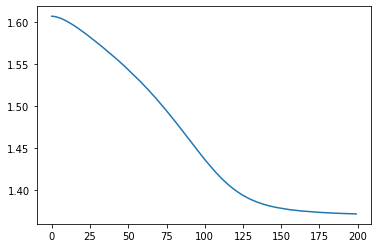

prediction accuracy 0.43073237812181164


In [ ]:
for epoch in range(200):
    optimizer.zero_grad()
    out = net(train_X)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('number of epoch', epoch, 'loss', loss.data)
    loss_epoch.append(loss.item())
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(test_X,test_y), evaluation(train_X,train_y)))
plt.plot(loss_epoch)
plt.show()
predict_out = net(test_X)
_, predict_y = torch.max(predict_out, 1)
print('prediction accuracy', accuracy_score(test_y.cpu().data.numpy(),predict_y.cpu().data.numpy()))

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(37, 512),
    torch.nn.Dropout(0.3),
    torch.nn.Tanh(),
    torch.nn.Linear(512, 512),
    torch.nn.Dropout(0.3),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 128),
    torch.nn.Dropout(0.3),
    torch.nn.ReLU(),
    torch.nn.Linear(128,128),
    torch.nn.Dropout(0.3),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.Dropout(0.3),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.Dropout(0.3),
    torch.nn.Tanh(),
    torch.nn.Linear(64,5))

number of epoch 0 loss tensor(1.6997, device='cuda:0')
Epoch: 0/1000, Test acc: 6.59, Train acc: 0.54
number of epoch 20 loss tensor(1.2837, device='cuda:0')
Epoch: 20/1000, Test acc: 43.07, Train acc: 53.46
number of epoch 40 loss tensor(1.0552, device='cuda:0')
Epoch: 40/1000, Test acc: 43.07, Train acc: 53.46
number of epoch 60 loss tensor(1.0033, device='cuda:0')
Epoch: 60/1000, Test acc: 43.07, Train acc: 53.46
number of epoch 80 loss tensor(0.9761, device='cuda:0')
Epoch: 80/1000, Test acc: 43.09, Train acc: 53.47
number of epoch 100 loss tensor(0.9371, device='cuda:0')
Epoch: 100/1000, Test acc: 43.26, Train acc: 53.81
number of epoch 120 loss tensor(0.8147, device='cuda:0')
Epoch: 120/1000, Test acc: 52.59, Train acc: 71.93
number of epoch 140 loss tensor(0.5066, device='cuda:0')
Epoch: 140/1000, Test acc: 66.32, Train acc: 86.50
number of epoch 160 loss tensor(0.3857, device='cuda:0')
Epoch: 160/1000, Test acc: 66.41, Train acc: 87.57
number of epoch 180 loss tensor(0.3438, de

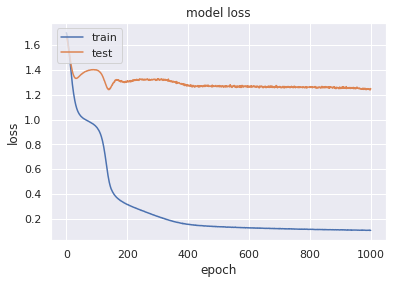

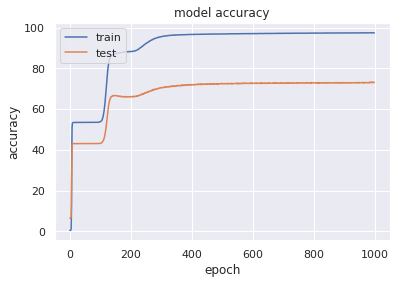

prediction accuracy 0.7320232444661314


In [ ]:
net = model.to(device)
loss_epoch = []
train_loss = []
test_loss = []
train_acc = []
test_acc = []
criterion = nn.CrossEntropyLoss()# cross entropy loss
optimizer = torch.optim.SGD(net.parameters(), lr=0.01,momentum=0.9)
max_epochs = 1000
for epoch in range(1000):
    optimizer.zero_grad()
    out = net(train_X)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print('number of epoch', epoch, 'loss', loss.data)
        print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(test_X,test_y), evaluation(train_X,train_y)))
    loss_epoch.append(loss.item())
    train_loss.append(loss.item())

    test_out = net(test_X)
    te_loss = criterion(test_out,test_y)
    test_loss.append(te_loss.item())

    tr_acc = evaluation(train_X,train_y)
    train_acc.append(tr_acc)

    te_acc = evaluation(test_X,test_y)
    test_acc.append(te_acc)

plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(train_acc)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predict_out = net(test_X)
_, predict_y = torch.max(predict_out, 1)
print('prediction accuracy', accuracy_score(test_y.cpu().data.numpy(),predict_y.cpu().data.numpy()))

In [ ]:
predict_y = predict_y.cpu().data.numpy()

In [ ]:
pd.crosstab(test_y.cpu().data.numpy(),predict_y, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1,2
Actual attacks,,,
0,8955,537,218
1,1562,5829,69
2,422,281,1718
3,2674,9,202
4,59,1,7


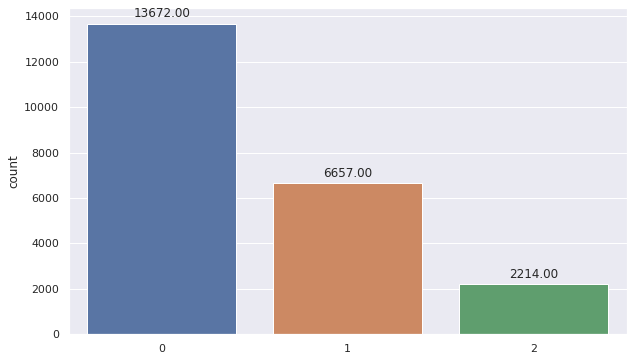

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x=predict_y)
for p in ax.patches:
  ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')